# Load Libraries
       Search for the best 2-layer optical nonlinear classifer for KMIST dataset with following conditions:
       Use the actual image taken from the setup as the physical ground truth (from 4 different ROIs)
       Use experimentally derived nonlinear activation function from 1 ROI (#0).
       The nonlinaer curve is extended to the saturation region of the image intensifier, and analytically fitted with a double exponential function (4 parameters).
       The output of the nonlinear activation function is normalized by dividing ~100 so that the output does not significantly exceed 1.
       NN strucutre: optical fc [784-36-4] + digital fc [4-10],
       Optical layers have non-negative weights, zero bias, 0.02 relative weight noise, and are randomly initiated.

In [1]:
from __future__ import print_function
import os, sys
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna
import ray

import wandb
from torchvision import datasets, transforms

# Overall Structure

There are three nested loops in a neural architecture search project:

    loop around sets of hyperparamters:
        loop around epoches for training of a model of a particular set of hyperparameters:
            loop around mini-batches in an epoch:

In [2]:
""" Training and hyperparameter search configurations """

parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=256, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=3000, metavar='N',
                    help='number of epochs to train (default: 100)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--gpus', default=0,
                    help='gpus used for training - e.g 0,1,3')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--wandb', action='store_true', default=True, 
                    help='enables wandb logger')  
parser.add_argument('--csv', action='store_true', default=False, 
                    help='enables csv logger')  
args = parser.parse_args("")
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds to reproduce results
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Dataloaders

In [3]:
class GT_QuickDraw_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_import, label_import, data_transforms=None):
        self.data = torch.tensor(data_import, dtype = torch.float32)
        self.targets = torch.tensor(label_import, dtype = torch.long)
        self.transform = data_transforms
                
    def __len__(self):
        return len(self.targets)
        
    def __getitem__(self, idx):
        data = self.data[idx]
        
        if self.transform:
             data = self.transform(self.data[idx].unsqueeze(0))
            
        return data, self.targets[idx]

In [4]:
""" Prepare data loaders """

data = np.load('./Quickdraw_GT_images_April_7.npz')

train_np = data['train_data']
train_labels = data['train_labels']

train_idx = []
val_idx = []
np.random.seed(42)
for l in np.unique(train_labels):
    class_idx = (train_labels == l).nonzero()[0]
    np.random.shuffle(class_idx)
    train_idx.append(class_idx[:250])
    val_idx.append(class_idx[250:])
train_idx = np.array(train_idx).flatten()
val_idx = np.array(val_idx).flatten()

val_np = train_np[val_idx,:,:]
val_labels = train_labels[val_idx]
train_np = train_np[train_idx,:,:]
train_labels = train_labels[train_idx]
test_np = data['test_data']
test_labels = data['test_labels']

transforms_input = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                            transforms.Lambda(lambda x: x/190)])

transforms_input_distort = transforms.Compose([transforms.RandomAffine(0, translate=(0.025, 0.025), scale=(0.96, 1.04)), \
                                         transforms.Lambda(lambda x: x.view(-1)), \
                                         transforms.Lambda(lambda x: x)])

kwargs = {}

""" Customerized samplers """
train_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(len(train_idx))), \
                                              batch_size=256, drop_last=False)
val_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(len(val_idx))), \
                                              batch_size=1000, drop_last=False)
test_sampler = torch.utils.data.BatchSampler(\
                                             torch.utils.data.RandomSampler(range(test_np.shape[0])), \
                                             batch_size=1000, drop_last=False)

""" input image loaders """
train_loader_phys = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(train_np, train_labels, transforms_input), \
    batch_sampler=train_sampler, **kwargs)

val_loader_phys = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(val_np, val_labels, transforms_input), \
    batch_sampler=val_sampler, **kwargs)

test_loader_phys = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(test_np, test_labels, transforms_input), \
    batch_sampler=test_sampler, **kwargs)

""" input image loaders """
train_loader_phys_order = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(train_np, train_labels, transforms_input), \
    batch_size=10000, shuffle=False, **kwargs)

test_loader_phys_order = torch.utils.data.DataLoader( \
    GT_QuickDraw_Dataset(test_np, test_labels, transforms_input), \
    batch_size=10000, shuffle=False, **kwargs)

In [5]:
next(enumerate(train_loader_phys))[1][0].shape

torch.Size([256, 1600])

# NN Definitions

In [6]:
class ONNLinear(nn.Module):
    def __init__(self, in_features, out_features, weight_noise=0.02, zeros_init=False):
        super(ONNLinear, self).__init__()
        self.W_Opt = \
            nn.Parameter(torch.randn(out_features, in_features, requires_grad = True) / math.sqrt(in_features)) \
            if not zeros_init else \
            nn.Parameter(torch.zeros(out_features, in_features, requires_grad = True)) 
        self.noise = weight_noise
        
    def forward(self, x):
        self.W_Opt.data = self.W_Opt.data.clamp_(0,1)
        out = F.linear(x + self.noise*torch.rand(x.shape, requires_grad=False, device=x.device), self.W_Opt)
        return out

def exp(Y, params):
    return torch.exp(-1.*torch.mul(Y, params))

def NL_func(Y, nonlinear_paramters):
    return torch.add(-1.*torch.mul(exp(Y, nonlinear_paramters[:, 1]), nonlinear_paramters[:, 0]) + \
                      -1.*torch.mul(exp(Y, nonlinear_paramters[:, 3]), nonlinear_paramters[:, 2]), \
                      nonlinear_paramters[:, 0]+nonlinear_paramters[:, 2])/50

class ONNIntensifier(nn.Module):
    def __init__(self, func, coeffs):
        super(ONNIntensifier, self).__init__()
        self.func = func
        self.params = coeffs
        
    def forward(self, x):
        out = self.func(x, self.params)
        return out

In [9]:
""" Definition of autoencoder structure """

coeffs = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

class OpticalClassifier0(nn.Module):
    def __init__(self, hidden_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
        self.fc1 = ONNLinear(1600, hidden_size, zeros_init=False)
        self.nonlinear = ONNIntensifier(NL_func, self.coeffs)
        self.fc2 = ONNLinear(hidden_size, 10)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.nonlinear(x)
        y = self.fc2(x)
        return y
    
class OpticalClassifier(nn.Module):
    def __init__(self, hidden_size, compressed_size, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
        self.fc1 = ONNLinear(1600, hidden_size, zeros_init=False)
        self.nonlinear = ONNIntensifier(NL_func, self.coeffs)
        self.fc2 = ONNLinear(hidden_size, compressed_size)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.nonlinear(x)
        x = self.fc2(x)
        y = self.digifc(x)
        return y

class digitalClassifier_ReLU(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        frontend = []
        for i, j in zip(Nunits[:-1], Nunits[1:]):
            frontend.append(nn.Linear(i,j,**kwargs))
            frontend.append(nn.ReLU())
        frontend.pop()
        self.frontend = nn.Sequential(*frontend)
        self.digifc = nn.Linear(Nunits[-1], 10, bias=True)

    def forward(self, X):
        X = self.frontend(X)
        X = self.digifc(X)
        return X
    
class digitalClassifier_Sigmoid(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        frontend = []
        for i, j in zip(Nunits[:-1], Nunits[1:]):
            frontend.append(nn.Linear(i,j,**kwargs))
            frontend.append(nn.Sigmoid())
        frontend.pop()
        self.frontend = nn.Sequential(*frontend)
        self.digifc = nn.Linear(Nunits[-1], 10, bias=True)

    def forward(self, X):
        X = self.frontend(X)
        X = self.digifc(X)
        return X

In [10]:
 """ helper functions and classes """
    
# A manager for dynamical book-keeping of the top k accuracies and model checkpoints during training
class top_k_manager(object):
    def __init__(self, k=10):
        self.k_best = k
        self.top_k_metric =[0.0]*self.k_best
        self.top_k_paths = [""]*self.k_best
    
    # Compare the new_metric to the top k metrics in the past, and find its place.
    def update_rank(self, new_metric, path_keeping):
        for rank, record_metric in enumerate(self.top_k_metric):
            if record_metric <= new_metric:    
                if os.path.exists(self.top_k_paths[-1]):
                    os.remove(self.top_k_paths[-1])
                if rank < self.k_best - 1:
                    self.top_k_metric[rank+1:] = self.top_k_metric[rank:-1]
                    self.top_k_paths[rank+1:] = self.top_k_paths[rank:-1]  
                self.top_k_metric[rank] = new_metric
                self.top_k_paths[rank] = path_keeping
                return True # the top k list has been updated
        return False
    
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

# Define training and testing loops for each epoch

    Explanation on quantization-aware training algorithm used in train():
    1. The activations are calculated with a forward passing, involving only quantized weights and activations. Meanwhile, the non-quantized version of the weights is still kept in memory for later use..
    2. The gradients are calculated with backprop based on the quantized activations and weights calucated in (1). 
    3. The non-quantized version of parameters (weights + biases) are updated with gradients, and saved without quantization. Quantizating parameters immediately after updating them can erase small updates.
    4. Quantization is only later performed on these parameters during the evaluation of activations in forward passing or errors in backprop. During these evaluation steps, a quantized copy of the non-quantized parameters are used. Meanwhile, the original non-quantized version stays unchanged until updated with the next batch of calculated gradients.
    PS: the clipping of the parameters represents the straight-through esimator across hard tanh nonlinear layers.


In [11]:
def train(epoch, model, optimizer, criterion, train_loader0):
    model.train()
    # Loop around mini-batches in an epoch
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader0):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        
        optimizer.step()
        
        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        """
        if batch_idx % args.log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
            +f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
        """
        if args.wandb:
            wandb.log({"train_loss": loss.item(), "batch": batch_idx}, step = epoch)
            
#     accuracy = 100.0 * correct/len(train_loader0.dataset)
#     print(f"Train Epoch: {epoch} \t\tLoss: {loss.item():.6f}\tAccuracy: {accuracy: .2f}%")

def test(epoch, model, criterion, test_loader0):
    model.eval()
    test_loss = 0
    correct = 0
    hks = [Hook(model.fc1), Hook(model.fc2)]
    # Loop around mini-batches in an epoch
    with torch.no_grad():
        for data, target in test_loader0:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            outputs = model(data)
            test_loss += criterion(outputs, target).item() # sum up batch loss
            pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader0)
    accuracy = 100. * correct / len(test_loader0.dataset)
    val_stats = {"val_loss": test_loss, "accuracy": accuracy}
    for i, hk in enumerate(hks):
        val_stats[f"fc{i+1}"] = wandb.Histogram(hks[i].output.cpu())      
    
    if epoch%100 == 0:
        print(f"\nTest set: Epoch {epoch}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader0.dataset)}" 
              +f"({accuracy:.0f}%)\n")

    if args.wandb:
        wandb.log(val_stats, step=epoch)
    return test_loss, accuracy

In [12]:
""" The objective function runs a trial in a NAS study (a loop around epochs) """

def objective(trial, NAS_project_name, gpu_id, train_loader0, test_loader0):

    # Define the hyperparameter search space
    batch_size = trial.suggest_categorical("batch_size", [256, 384, 512])
    lr_factor0 = 2E-4 
    lr_factor = trial.suggest_uniform("lrf", lr_factor0/8, lr_factor0*5)
    learning_rate = lr_factor * np.sqrt(batch_size/256)
    swa_lr = trial.suggest_uniform("swa_lr", 1E-5, 1E-3)
    beta1 = trial.suggest_uniform("beta1", 0.99, 0.9999)
    beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
    swa_start = trial.suggest_categorical("swa_start", [1500, 2000])
    #warmup_epochs = trial.suggest_categorical("warmup_eps", [18, 24, 30])
    #model_description = f"Autoencoder_QAT_ar5wd5_lr_{learning_rate:.3f}_{lr_decay:.2f}" + f"_m_{momentum:.2f}" + f"_wp_{warmup_epochs}"+ f"_v_{trial.number}"
    model_description = f"AllOpt_H256_lr_{learning_rate:.6f}_bs_{batch_size}_b1_{beta1:.4f}_b2_{beta2:.4f}_swalr_{swa_lr:.6f}_{swa_start}" + f"_v_{trial.number}"
    
    # Instantiate a BNN model
    model = OpticalClassifier0(256)
#     model_ckpt = torch.load("./Gen3_fc2_finetune_v12_ep1037.pt", map_location=torch.device('cpu')) 
#     model_state_dict = model_ckpt["model_state_dict"]
#     model.load_state_dict(model_state_dict)
#     model.fc1.W_Opt.requires_grad = False
#     model.fc2.W_Opt.requires_grad = False
    if args.cuda:
        torch.cuda.set_device(gpu_id)
        model.cuda() # transfer the model from cpu to gpu
    
    # Set up logging if necessary
    if args.wandb:
        wandb.init(project=NAS_project_name, name=model_description, reinit=True)
        wandb.watch(model, log="all")

    # Configure loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=0e-4)
    
    swa_model = AveragedModel(model)
    scheduler = CosineAnnealingLR(optimizer, T_max=swa_start+500)
    swa_scheduler = SWALR(optimizer, swa_lr=swa_lr)
    
    train_loader0.batch_sampler.batch_size = batch_size

    # Loop around epoches
    tpk_mngr = top_k_manager()
    ckpt_save_path = "./" + model_description
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
    for epoch in range(1, args.epochs + 1):
        train(epoch, model, optimizer, criterion, train_loader0)
        loss, accu = test(epoch, model, criterion, test_loader0)
        # schedule learning rate decay
        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()
        # Save the best models aftering the training gets more stable
        if epoch > 30:
            if tpk_mngr.update_rank(accu, ckpt_save_path+f"/ep{epoch}.pt"):
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, ckpt_save_path+f"/ep{epoch}.pt")

    # Log the best models
    trial.set_user_attr('top 3 accuracy', torch.tensor(tpk_mngr.top_k_metric[:3]).mean().item()) # Save the best accuracy during the taining loop      
    if args.wandb:
        wandb.run.summary["top_k_accu"] = tpk_mngr.top_k_metric
        wandb.run.summary["top_k_paths"] = tpk_mngr.top_k_paths
    return torch.tensor(tpk_mngr.top_k_metric[:30]).mean().item() # return the average of top k accuracies to guide NAS

In [11]:
""" Remote projects for NAS by running an optuna study on a thread """

@ray.remote(num_cpus=0.2, num_gpus=0.2)
class Parallel_NAS_project(object):
    def __init__(self, NAS_project_name, rseed, gpu_id):
        os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
        torch.cuda.set_device(gpu_id)
        self.sampler = optuna.samplers.TPESampler(seed=rseed) 
        self.storage = f'sqlite:///'+NAS_project_name+'.db' # way to specify an SQL database
        self.study = optuna.create_study(study_name=NAS_project_name, storage=self.storage, 
                                sampler=self.sampler, direction="maximize", load_if_exists=True)
    
    def runStudy(self, gpu_id, train_loader, test_loader):
        self.study.optimize(lambda trial: objective(trial, NAS_project_name, gpu_id, train_loader, test_loader), n_trials=18)

In [ ]:
""" Create remote projects for NAS """

ray.init(num_gpus=4, ignore_reinit_error=True)
gpu_list = [0,0,0]
rseeds = [1514,6,21,93258,2135]

NAS_project_name = "Quickdraw_Nov_24_OONA"
workerList = []
for (rseed, gpu_id) in zip(rseeds, gpu_list): 
    worker = Parallel_NAS_project.remote(NAS_project_name, rseed, gpu_id)
    workerList.append(worker)
    print(rseed, gpu_id) 

#train_loader_id = ray.put(train_loader) # important for large data loaders, since they would surpass memory limit if passed as parameters to study functions.
#test_loader_id = ray.put(test_loader)
remaining_ids = []
for i, w in enumerate(workerList):
    test_id = w.runStudy.remote(gpu_list[i], train_loader_phys, val_loader_phys)
    remaining_ids.append(test_id)

while remaining_ids:
    done_ids, remaining_ids = ray.wait(remaining_ids)
    result_id = done_ids[0]
    print(done_ids, remaining_ids)
    ray.get(result_id)
    
ray.shutdown()

1514 0
6 0
21 0


(Parallel_NAS_project pid=98099) [I 2022-11-24 22:48:46,730] Using an existing study with name 'Quickdraw_Nov_24_OONA' instead of creating a new one.
(Parallel_NAS_project pid=98123) [I 2022-11-24 22:48:46,795] Using an existing study with name 'Quickdraw_Nov_24_OONA' instead of creating a new one.
(Parallel_NAS_project pid=97957) [I 2022-11-24 22:48:46,871] Using an existing study with name 'Quickdraw_Nov_24_OONA' instead of creating a new one.
(Parallel_NAS_project pid=98099) wandb: Currently logged in as: gangsterkitty (use `wandb login --relogin` to force relogin)
(Parallel_NAS_project pid=98123) wandb: Currently logged in as: gangsterkitty (use `wandb login --relogin` to force relogin)
(Parallel_NAS_project pid=97957) wandb: Currently logged in as: gangsterkitty (use `wandb login --relogin` to force relogin)
(Parallel_NAS_project pid=98123) 2022-11-24 22:48:55.008922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'

In [13]:
ray.shutdown()

# Check inputs

In [13]:
%matplotlib notebook

<IPython.core.display.Javascript object>


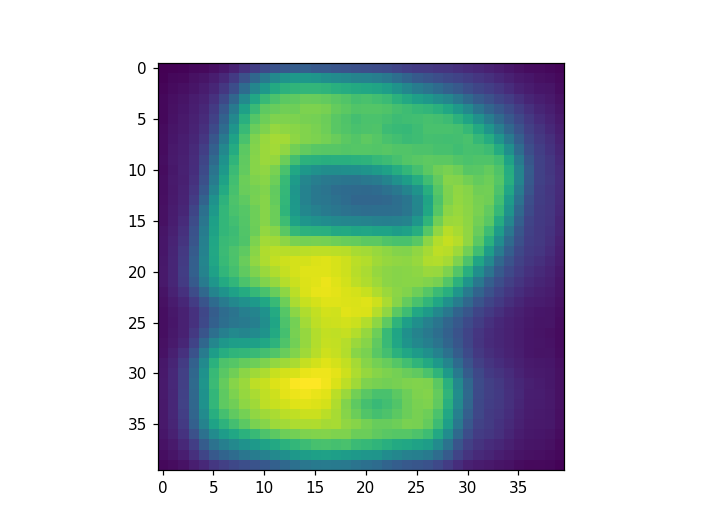

In [14]:
import matplotlib.pyplot as plt

#train_data = GT_MNIST_Dataset(train_np, train_labels, transforms_distort)
#train_data0 = GT_MNIST_Dataset(train_np, train_labels, transforms_validation)
idx = 60
fig, axes = plt.subplots(1,1)
plt.imshow(next(enumerate(train_loader_phys))[1][0][0,:].view(40,-1))
#print(train_data0[idx][1])

# Tests

In [17]:
args.wandb = False

model = OpticalClassifier0(36)

#digifc_init_params = model.digifc._parameters
model_ckpt = torch.load("./models/AllOpt_ep2091.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

criterion = nn.CrossEntropyLoss()
loss, accu = test(1, model.cuda(), criterion, test_loader_phys)
print(accu)


tensor(85.7426)


In [19]:
args.wandb = False

model = OpticalClassifier0(128)

#digifc_init_params = model.digifc._parameters
# model_ckpt = torch.load("./AllOpt_H128_lr_0.003321_bs_384_b1_0.9985_b2_0.9991_swalr_0.000556_2000_v_60/ep1425.pt", map_location=torch.device('cpu')) 
model_ckpt = torch.load("./models/AllOpt_ep2855.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

criterion = nn.CrossEntropyLoss()
loss, accu = test(1, model.cuda(), criterion, test_loader_phys)
print(accu)

tensor(87.3267)


In [20]:
args.wandb = False

model = OpticalClassifier0(256)

#digifc_init_params = model.digifc._parameters
model_ckpt = torch.load("./models/AllOpt_ep2589.pt", map_location=torch.device('cpu')) 
# model_ckpt = torch.load("./AllOpt_H256_lr_0.001731_bs_512_b1_0.9980_b2_0.9992_swalr_0.000504_2000_v_82/ep660.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

criterion = nn.CrossEntropyLoss()
loss, accu = test(1, model.cuda(), criterion, test_loader_phys)
print(accu)

tensor(88.1188)


In [33]:
print(torch.__version__, optuna.__version__, ray.__version__)

1.11.0+cu102 1.5.0 1.11.0
